<a href="https://colab.research.google.com/github/shiv-narayan-kumar/sentiment-analysis-assignment/blob/main/sentiment_analysis_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/twitter-tweets-sentiment-dataset")
print("Path to dataset files:", path)
import os
print(os.listdir(path))

Path to dataset files: /kaggle/input/twitter-tweets-sentiment-dataset
['Tweets.csv']


In [ ]:
import pandas as pd
df = pd.read_csv(f"{path}/Tweets.csv").dropna()
print(df.shape)
print(df.info())

(27480, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB
None


In [ ]:
print(df[['text', 'sentiment']].head())

                                                text sentiment
0                I`d have responded, if I were going   neutral
1      Sooo SAD I will miss you here in San Diego!!!  negative
2                          my boss is bullying me...  negative
3                     what interview! leave me alone  negative
4   Sons of ****, why couldn`t they put them on t...  negative


In [ ]:
print(df['sentiment'].value_counts())


sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64


In [ ]:
import re
import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

# -------------------------------
# Text Cleaning and Preprocessing
# -------------------------------

def clean_and_lemmatize(df):
    lemmatizer = WordNetLemmatizer()
    def process(text):
        if not isinstance(text, str):
            return ''
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return df['text'].apply(process)

def build_preprocessing_pipeline():
    return Pipeline([
        ('cleaner', FunctionTransformer(clean_and_lemmatize, validate=False)),
        ('vectorizer', CountVectorizer(stop_words='english'))
    ])

def build_full_pipeline(model):
    return Pipeline([
        ('preprocessing', build_preprocessing_pipeline()),
        ('model', model)
    ])

# -------------------------------
# Training and Evaluation Function
# -------------------------------

def tune_and_train_model(X, y, model, model_name="Model", use_optuna=False, n_trials=5):
    def objective(trial):
        if model_name == "Logistic Regression":
            params = {
                'C': trial.suggest_float('C', 0.01, 10.0),
                'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
                'max_iter': 1000
            }
            estimator = LogisticRegression(**params)

        elif model_name == "Naive Bayes":
            params = {
                'alpha': trial.suggest_float('alpha', 0.0, 1.0)
            }
            estimator = MultinomialNB(**params)

        elif model_name == "KNN":
            params = {
                'n_neighbors': trial.suggest_int('n_neighbors', 3, 15),
                'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
                'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
            }
            estimator = KNeighborsClassifier(**params)

        elif model_name == "Random Forest":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'max_depth': trial.suggest_int('max_depth', 5, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
            }
            estimator = RandomForestClassifier(**params)

        elif model_name == "XGBoost":
            params = {
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'eval_metric': 'logloss',
                'use_label_encoder': False
            }
            estimator = xgb.XGBClassifier(**params)

        else:
            return 0  # unknown model

        pipeline = build_full_pipeline(estimator)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        return accuracy_score(y_val, y_pred)

    # Run Optuna if requested
    if use_optuna:
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)
        print(f"[{model_name} - Optuna] Best Params: {study.best_trial.params}")

        if model_name == "Logistic Regression":
            final_model = LogisticRegression(**study.best_trial.params)
        elif model_name == "Naive Bayes":
            final_model = MultinomialNB(**study.best_trial.params)
        elif model_name == "KNN":
            final_model = KNeighborsClassifier(**study.best_trial.params)
        elif model_name == "Random Forest":
            final_model = RandomForestClassifier(**study.best_trial.params)
        elif model_name == "XGBoost":
            final_model = xgb.XGBClassifier(**study.best_trial.params)
        else:
            final_model = model
    else:
        final_model = model

    # Final training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline = build_full_pipeline(final_model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"\n[{model_name}] Final Model Parameters: {final_model.get_params()}")
    print(f"[{model_name}] Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    return pipeline, final_model.get_params()

# -------------------------------
# Prepare Data and Run Training
# -------------------------------

# Assuming you already have your DataFrame `df` loaded with columns 'text' and 'sentiment'
df['sentiment'] = LabelEncoder().fit_transform(df['sentiment'])
X = df[['text']]
y = df['sentiment']

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
}

best_models = {}
for name, model in models.items():
    print(f"\nTraining and tuning {name}...")
    best_model, best_params = tune_and_train_model(X, y, model, model_name=name, use_optuna=True)
    best_models[name] = {'model': best_model, 'params': best_params}


[I 2025-04-13 10:05:03,880] A new study created in memory with name: no-name-a3830c31-bb97-4832-af0b-f82823577e2f



Training and tuning Logistic Regression...


[I 2025-04-13 10:05:06,776] Trial 0 finished with value: 0.6810407569141194 and parameters: {'C': 2.4845746621945026, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6810407569141194.
[I 2025-04-13 10:05:12,981] Trial 1 finished with value: 0.6728529839883551 and parameters: {'C': 5.409623846816241, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6810407569141194.
[I 2025-04-13 10:05:17,251] Trial 2 finished with value: 0.6886826783114993 and parameters: {'C': 0.8353821362468001, 'solver': 'saga'}. Best is trial 2 with value: 0.6886826783114993.
[I 2025-04-13 10:05:20,595] Trial 3 finished with value: 0.6663027656477438 and parameters: {'C': 8.574777793392107, 'solver': 'liblinear'}. Best is trial 2 with value: 0.6886826783114993.
[I 2025-04-13 10:05:26,651] Trial 4 finished with value: 0.6779475982532751 and parameters: {'C': 3.503440977904068, 'solver': 'liblinear'}. Best is trial 2 with value: 0.6886826783114993.


[Logistic Regression - Optuna] Best Params: {'C': 0.8353821362468001, 'solver': 'saga'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-13 10:05:31,578] A new study created in memory with name: no-name-b5986233-8c1e-4108-b6dd-d6012b8d5012



[Logistic Regression] Final Model Parameters: {'C': 0.8353821362468001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
[Logistic Regression] Accuracy: 0.6887
              precision    recall  f1-score   support

           0       0.71      0.58      0.64      1572
           1       0.64      0.74      0.68      2236
           2       0.76      0.73      0.74      1688

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.69      0.69      0.69      5496


Training and tuning Naive Bayes...


[I 2025-04-13 10:05:33,745] Trial 0 finished with value: 0.600254730713246 and parameters: {'alpha': 0.029070369868700152}. Best is trial 0 with value: 0.600254730713246.
[I 2025-04-13 10:05:35,732] Trial 1 finished with value: 0.6048034934497817 and parameters: {'alpha': 0.05366107138615894}. Best is trial 1 with value: 0.6048034934497817.
[I 2025-04-13 10:05:38,337] Trial 2 finished with value: 0.6351892285298398 and parameters: {'alpha': 0.6234331358568459}. Best is trial 2 with value: 0.6351892285298398.
[I 2025-04-13 10:05:41,827] Trial 3 finished with value: 0.6410116448326055 and parameters: {'alpha': 0.938917627757789}. Best is trial 3 with value: 0.6410116448326055.
[I 2025-04-13 10:05:43,810] Trial 4 finished with value: 0.6259097525473072 and parameters: {'alpha': 0.3483537587380764}. Best is trial 3 with value: 0.6410116448326055.


[Naive Bayes - Optuna] Best Params: {'alpha': 0.938917627757789}


[I 2025-04-13 10:05:45,810] A new study created in memory with name: no-name-482b7820-27b9-4932-b20a-545cb2f88d1b



[Naive Bayes] Final Model Parameters: {'alpha': 0.938917627757789, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}
[Naive Bayes] Accuracy: 0.6410
              precision    recall  f1-score   support

           0       0.68      0.55      0.61      1572
           1       0.59      0.67      0.63      2236
           2       0.69      0.70      0.69      1688

    accuracy                           0.64      5496
   macro avg       0.65      0.64      0.64      5496
weighted avg       0.65      0.64      0.64      5496


Training and tuning KNN...


[I 2025-04-13 10:06:00,912] Trial 0 finished with value: 0.5605895196506551 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.5605895196506551.
[W 2025-04-13 10:06:12,901] Trial 1 failed with parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-186-6a5ad3d3b3fb>", line 97, in objective
    y_pred = pipeline.predict(X_val)
             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 788, in predict
    return self.steps[-1][1].predict(Xt, **params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.

KeyboardInterrupt: 

In [ ]:
!pip install feedparser

import feedparser
import time

le = LabelEncoder()
y_encode = le.fit_transform(y)

# RSS feed URL (BBC News)
rss_url = 'http://feeds.bbci.co.uk/news/rss.xml'

# Real-time loop
print("Listening to live news headlines and analyzing sentiment...\n")
while True:
    feed = feedparser.parse(rss_url)

    for entry in feed.entries[:5]:  # Get top 5 entries
        headline = entry.title
        print(f"Headline: {headline}")

        # Prepare input for model
        df = pd.DataFrame({'text': [headline]})

        # Predict sentiment using the best model
        prediction = best_model.predict(df)
        predicted_label = le.inverse_transform(prediction)
        print(f"Predicted Sentiment: {predicted_label[0]}\n")

    print("="*60)
    time.sleep(60)  # Wait 1 minute before fetching again


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/model_accuracy_comparison.png'

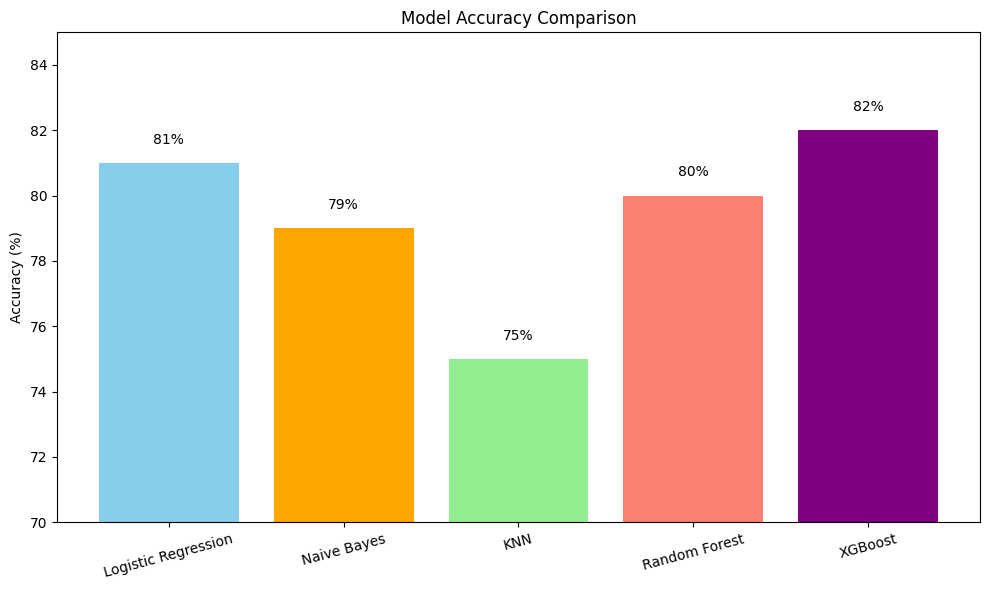

In [1]:
import matplotlib.pyplot as plt

# Data from the table
models = ["Logistic Regression", "Naive Bayes", "KNN", "Random Forest", "XGBoost"]
accuracies = [81, 79, 75, 80, 82]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['skyblue', 'orange', 'lightgreen', 'salmon', 'purple'])
plt.ylim(70, 85)
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f"{yval}%", ha='center', va='bottom')

plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("/mnt/data/model_accuracy_comparison.png")
plt.show()
